这是我对于Unet和attention_YNet的尝试，试着把Ynet用到的处理方式应用到Unet上。

这是第一部分,包含了:
基础导入和工具函数
图像处理类(填充/还原)
数据集类
数据加载器创建函数

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import math
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm

# 自定义的函数模块
from functions.data import prepare_dataset
from functions.model import UNet
from functions.data import SegmentationDataset
from functions.imagePreprocessing import ImagePreprocessor


### 检查imagePreprocessor类的预处理情况

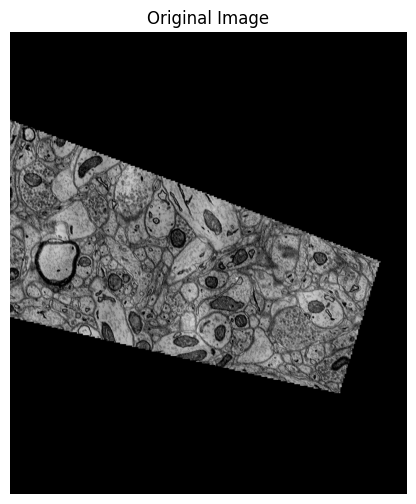

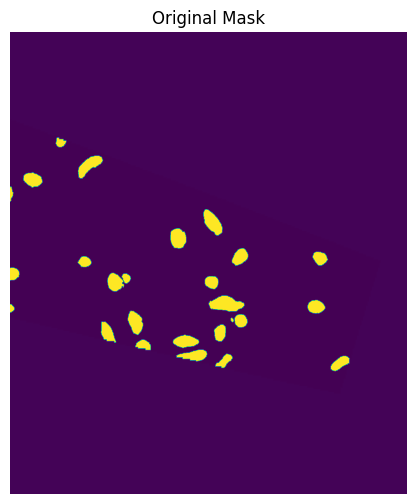

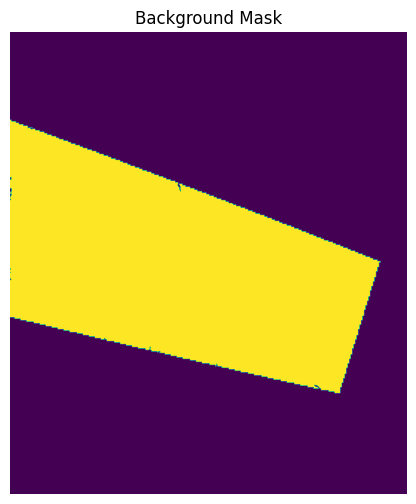

normalize_image done
histogram_equalization done
adjust_contrast done
adjust_brightness done
handle_transparent_edges done
check_and_pad_image done


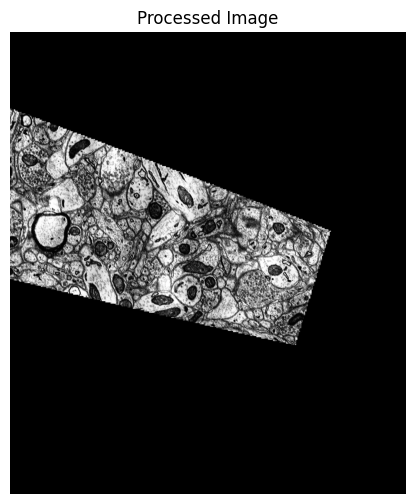

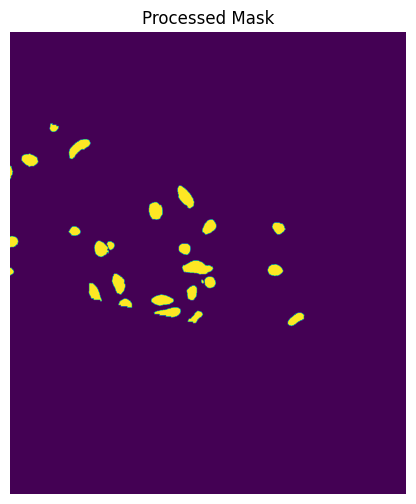

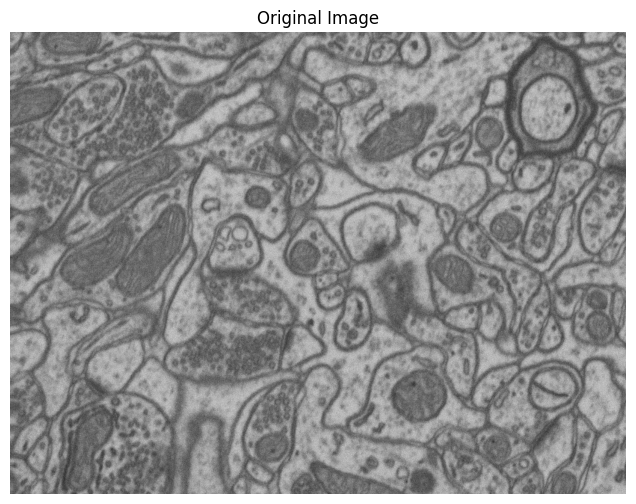

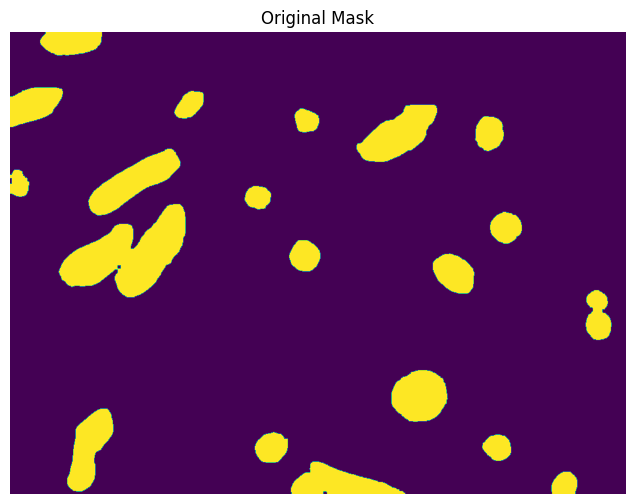

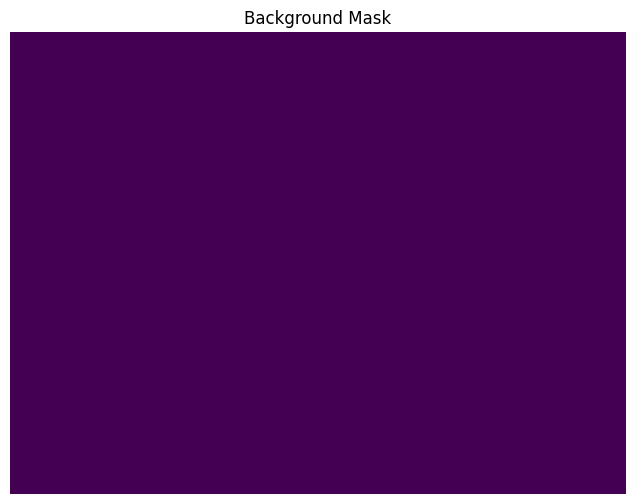

normalize_image done
histogram_equalization done
adjust_contrast done
adjust_brightness done
handle_transparent_edges done
check_and_pad_image done


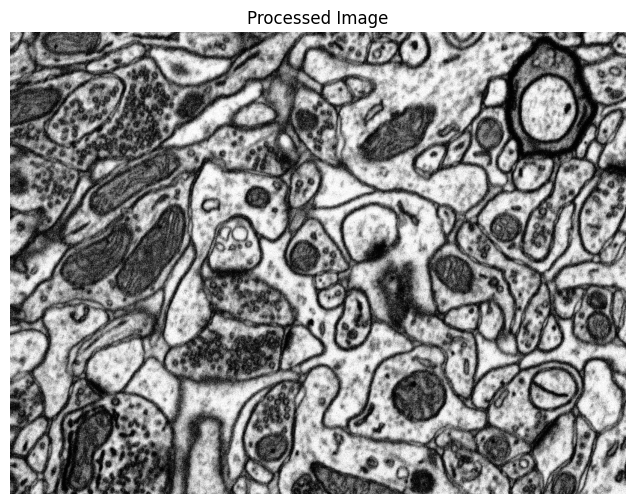

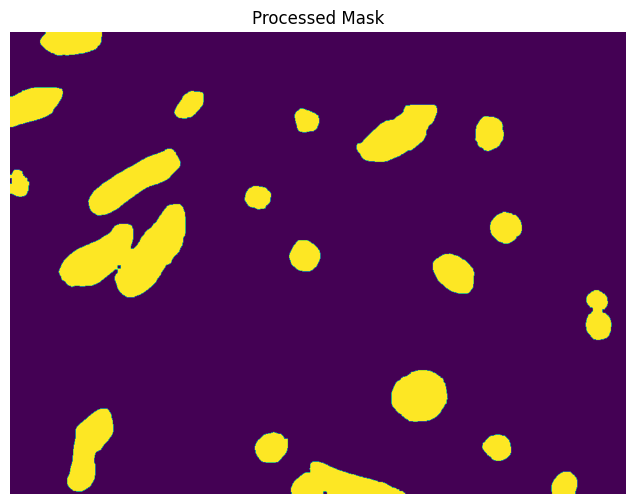

In [2]:
from functions.imagePreprocessing import ImagePreprocessor

image_path1 = "dataset\Kasthuri++\Test_In\mask1041.png" 
mask_path1 = "dataset\Kasthuri++\Test_Out\mask1041.png"

#Lucchi++ dataset
image_path2 = "dataset\Lucchi++\Test_In\mask0002.png" 
mask_path2 = "dataset\Lucchi++\Test_Out/2.png"


patch_size1 = 256
patch_size2 = 256

p = ImagePreprocessor()
processed_image1, processed_mask1,processed_background_mask1 = p.preprocess_show(image_path1, mask_path1, patch_size1,value=0,alpha=1.0)
processed_image2, processed_mask2,processed_background_mask2 = p.preprocess_show(image_path2, mask_path2, patch_size2,value=0,alpha=1.0)
#


In [4]:
import os
import cv2

# Define the save directory
save_dir = "dataset/processed"

# Create the save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the processed image1
cv2.imwrite(os.path.join(save_dir, "processed_image1.png"), cv2.cvtColor(processed_image1, cv2.COLOR_RGB2BGR))

# Save the processed mask1
cv2.imwrite(os.path.join(save_dir, "processed_mask1.png"), processed_mask1)

# Save the processed mask background1
cv2.imwrite(os.path.join(save_dir, "processed_mask_background1.png"), processed_background_mask1)

# Save the processed image2
cv2.imwrite(os.path.join(save_dir, "processed_image2.png"), cv2.cvtColor(processed_image2, cv2.COLOR_RGB2BGR))

# Save the processed mask2
cv2.imwrite(os.path.join(save_dir, "processed_mask2.png"), processed_mask2)

# Save the processed mask background2
cv2.imwrite(os.path.join(save_dir, "processed_mask_background2.png"), processed_background_mask2)
print("Processed image and mask saved successfully!")

Processed image and mask saved successfully!


### 测试dataset的patch分割是否正确

In [5]:
train_data, test_data = prepare_dataset("Kasthuri++") # Lucchi++ /  Kasthuri++ / VNC
PATCH_SIZE = 128 #这个暂时不需要理会，和下面的内容没关系
# # Path to the chest-ct-segmentation dataset folder
# data_dir = "dataset\Lucchi++" 
# train_images_dir = os.path.join(data_dir, "Train_In")
# train_masks_dir = os.path.join(data_dir, "Train_Out")
# test_images_dir = os.path.join(data_dir, "Test_In")
# test_masks_dir = os.path.join(data_dir, "Test_Out")


# i = 0
# # Prepare the training data, Append image and corresponding mask paths
# train_data = []
# for image_file in os.listdir(train_images_dir):
#     image_path = os.path.join(train_images_dir, image_file)
#     mask_path = os.path.join(train_masks_dir, f"{i}.png")
#     i += 1
#     train_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })

# i = 0
# # Prepare the test data, Append image and corresponding mask paths
# test_data = []
# for image_file in os.listdir(test_images_dir):
#     image_path = os.path.join(test_images_dir, image_file)
#     mask_path = os.path.join(test_masks_dir, f"{i}.png")
#     i += 1
#     test_data.append(
#     { 
#         "image" : image_path, 
#         "annotation" : mask_path
#     })
# print(train_data)



Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

In [6]:
# 创建数据集
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=128,                # 可选：patch大小，默认128
    stride=64,                     # 可选：滑动步长，默认64
    transform=None,
    # preProcessing= None# 可选：数据增强转换，默认None
)

# test_dataset= SegmentationDataset(
#     data_list=train_data,          # 必需：数据列表
#     patch_size=128,                # 可选：patch大小，默认128
#     stride=64,                     # 可选：滑动步长，默认64
#     transform=None                 # 可选：数据增强转换，默认None
# )


数据集信息:
总样本数: 48875
图像块大小: 128x128
滑动步长: 64
是否使用数据增强: 否

数据形状:
图像块形状: torch.Size([3, 128, 128])
掩码块形状: torch.Size([1, 128, 128])

显示图片的patches: mask1047.png
原图路径: dataset\Kasthuri++\Train_In\mask1047.png
对应的Mask路径: dataset\Kasthuri++\Train_Out\mask1047.png
图片索引: 16


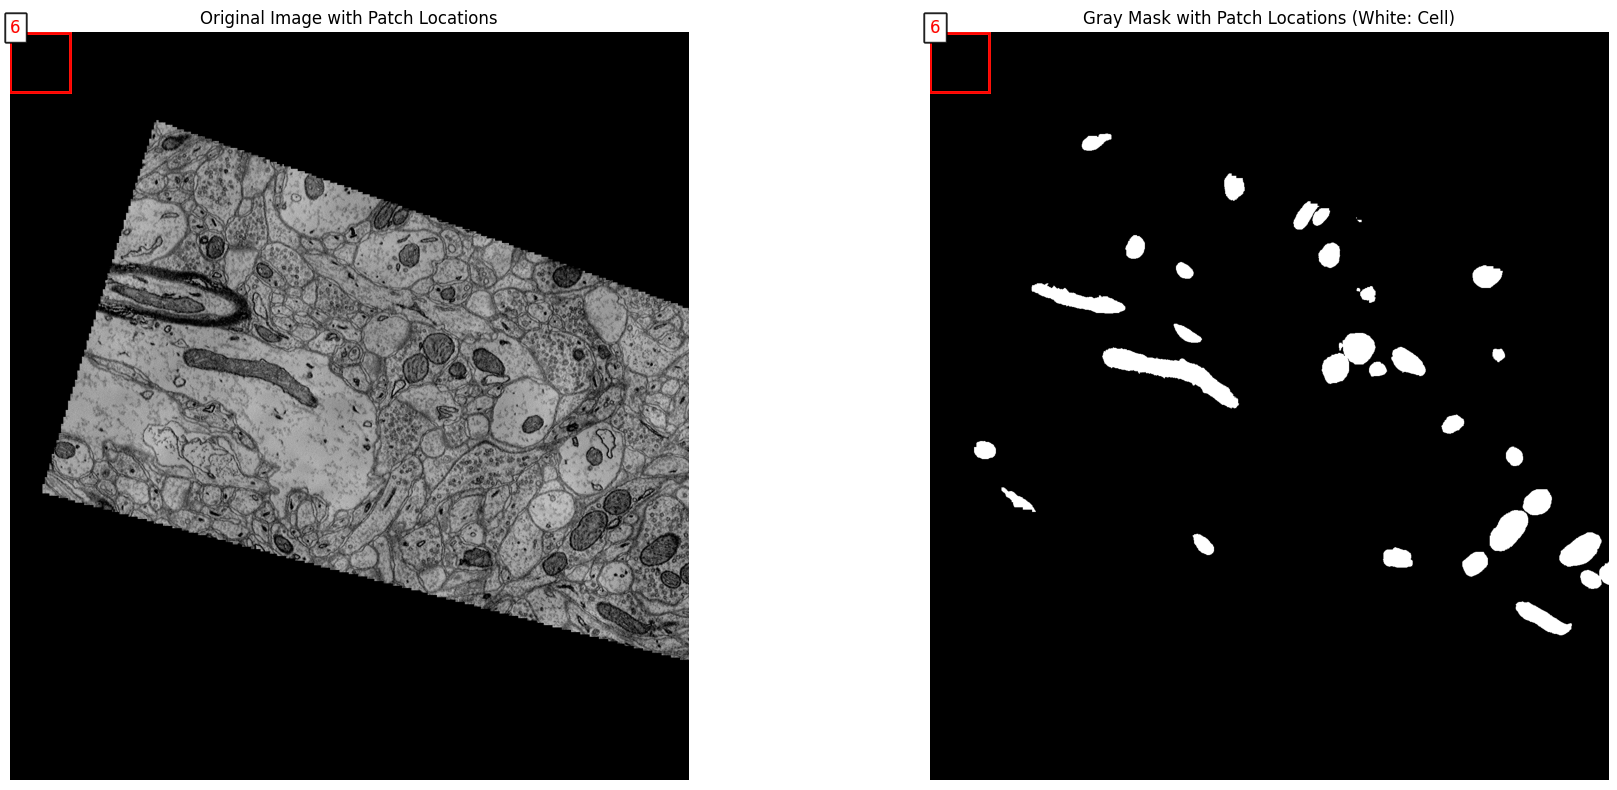

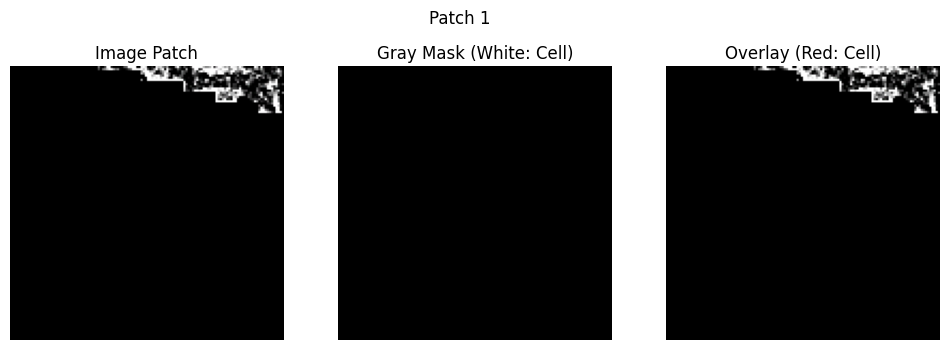

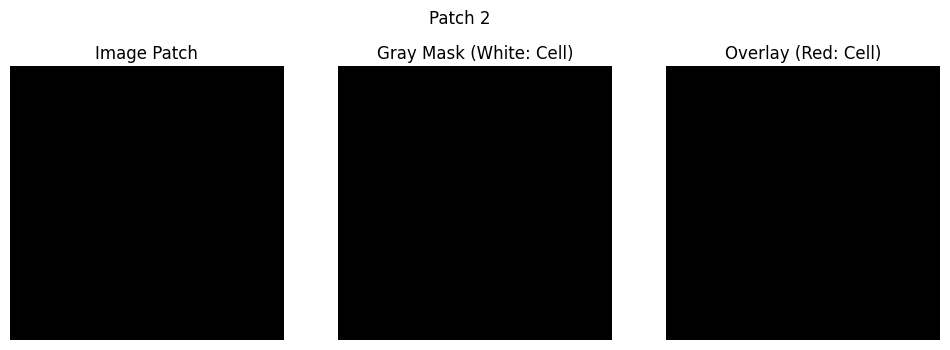

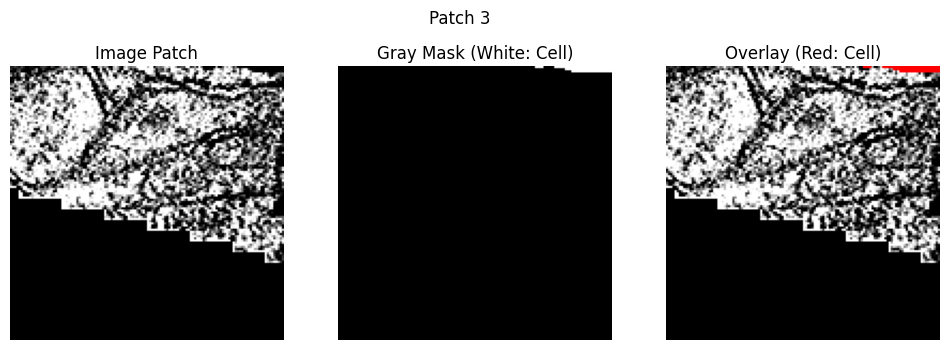

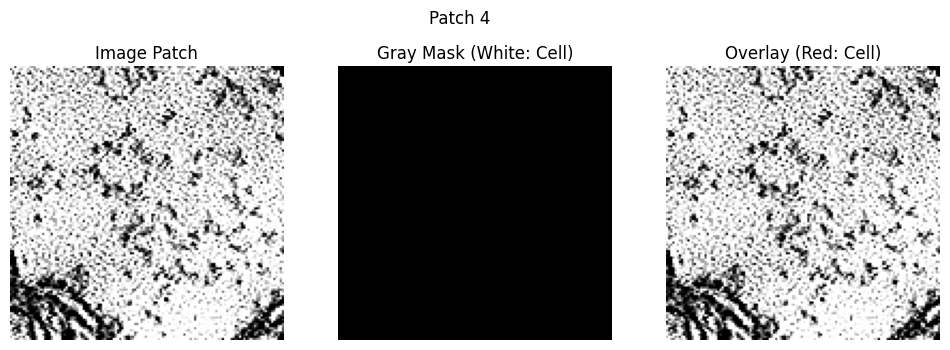

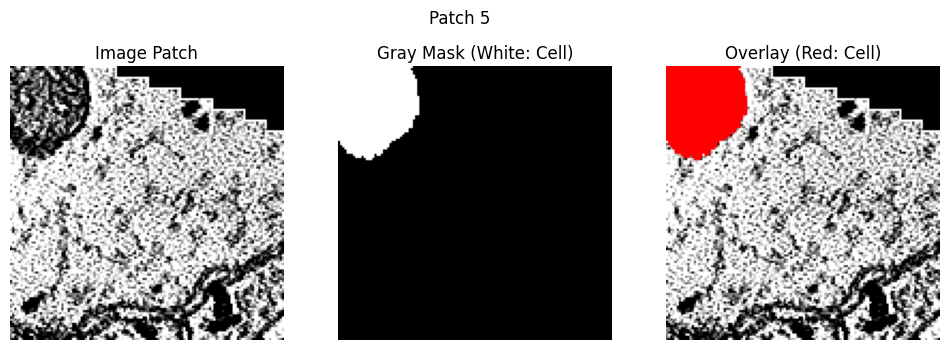

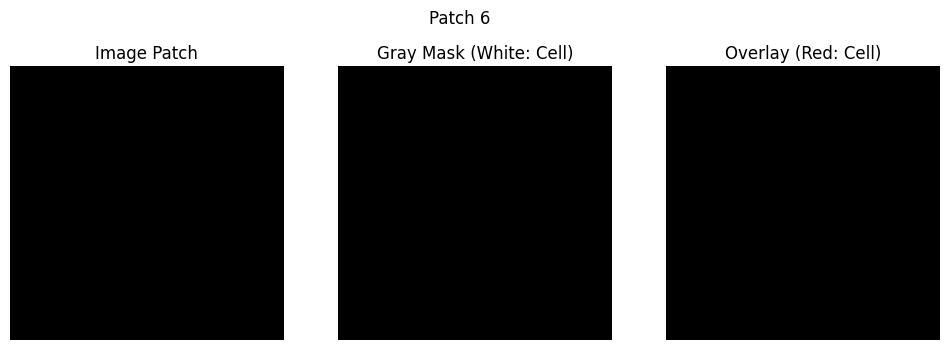

In [9]:
# 打印数据集基本信息
train_dataset.print_dataset_info()

# 随机查看几张图片的patches
train_dataset.visualize_random_images(num_images=1, patches_per_image=6)



# 下面是训练:  
   曾经的回顾：2025.0226之前的 测试： train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
patch_size=128, stride=64   


100%|██████████| 1702/1702 [21:33<00:00,  1.32it/s]
Epoch 1/50:
Train Loss: 0.0931, IoU: 0.7630, Dice: 0.8512
Val Loss: 0.0560, IoU: 0.7202, Dice: 0.8242
100%|██████████| 1702/1702 [30:43<00:00,  1.08s/it]
Epoch 2/50:
Train Loss: 0.0175, IoU: 0.9148, Dice: 0.9547
Val Loss: 0.0529, IoU: 0.7448, Dice: 0.8404
100%|██████████| 1702/1702 [30:27<00:00,  1.07s/it]
Epoch 3/50:
Train Loss: 0.0120, IoU: 0.9370, Dice: 0.9672
Val Loss: 0.0635, IoU: 0.7372, Dice: 0.8368

训练：
原始图像/掩码 -> 切分为128x128 patches(stride=64) -> 数据标准化(/255.0) -> 通道转换(HWC->CHW) -> 训练数据集构建
                                                                                                    ↓
                                                                                              模型训练循环
                                                                                                    ↓
                                                                                        保存最佳模型(IoU/Loss)

预测：
输入图像 -> 保持原始尺寸 -> 切分重叠patches(overlap=64) -> 数据标准化和通道转换 -> 模型预测
                                                                                    ↓
                                                            输出完整掩码 <- 加权重建 <- patch级预测结果


可使用counterbalance做对抗，train的部分需要在与处理下保证不同类的数据集特征倾向一致（这个之前没有做好导致泛化效率低）

首要目标：train和test的patch分割，都要使用patch进行，保证重叠度
         train部分的预处理操作不够完善（旋转和缩放没有设置，可能导致斜放图片以及比例不同的图片准确度下降），导致AB类数据集特征倾向不一致，泛化能力差
         后处理部分，目前只进行了形态学的消去小噪点，后续可以进行优化(打点，填充，闭运算等) 
         模块提取 后处理和预处理的内容
         还要加一个打点，这个可以去turnfinesam2那边找，记得把sam的内容也丢进来
        下面的是get point的方法，在 turnfinesam2_fix那边，要注意看！！！！把取点的后处理也拖动到unet中
         def get_points(mask, num_points):  # Sample points inside the input mask
            points = []
            coords = np.argwhere(mask > 0)
            for i in range(num_points):
                yx = np.array(coords[np.random.randint(len(coords))])
                points.append([[yx[1], yx[0]]])
            return np.array(points)
        这个函数可以随机选取mask中点，然后返回，这样偏差会小一些，记住！打点操作是后处理

准备尝试轻量化的数据测试，从1702降下来，看看整体效果，并且虽然加入了patch分割训练，但是还需要添加数据的预处理，比如颜色对比度的normalization，以及数据增强，还有对载入图片旋转训练（可以考虑加入其他数据进行验证，即Lucchi++和Kasthrui++混合训练），图像的后处理部分暂时可以先维持形态学的消去小噪点，后续再进行优化。

核心问题：model基础效果太差导致跨数据测试完全没效果，最大因素或许不在于size，而是颜色以及图片的细胞大小(即图片所占比例)，则测试准确度骤降，这点可以通过VNC和lucchi++数据集进行验证得到的，Lucchi model对VNC的测试甚至不如Kasthrui，但是看图片会发现虽然三类的数据集size都不一样，VNC颜色对比与K接近，而Lucchi偏向于浅色，这点也会影响模型的效果。


In [2]:

# 使用例子 model = UNet(num_classes=1).to(device)，下面是原注释

# class SegmentationModel(nn.Module):
#     def __init__(self, num_classes):
#         super(SegmentationModel, self).__init__()
        
#         # Encoder (downsampling)
#         self.encoder = nn.Sequential(
#             self.conv_block(3, 32, stride=2),
#             self.conv_block(32, 64, stride=2),
#             self.conv_block(64, 128, stride=2),
#             self.conv_block(128, 256, stride=2)
#         )
        
#         # Decoder (upsampling)
#         self.decoder = nn.Sequential(
#             self.upconv_block(256, 128),
#             self.upconv_block(128, 64),
#             self.upconv_block(64, 32),
#             self.upconv_block(32, 32)
#         )
        
#         # Final classification layer
#         self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)
        
#     def conv_block(self, in_channels, out_channels, stride=1):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def upconv_block(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
    
#     def forward(self, x):
#         # Encoder
#         features = []
#         for encoder_layer in self.encoder:
#             x = encoder_layer(x)
#             features.append(x)
        
#         # Decoder
#         for i, decoder_layer in enumerate(self.decoder):
#             x = decoder_layer(x)
#             if i < len(self.decoder) - 1:
#                 x = x + features[-i-2]  # Skip connection
        
#         # Final classification
#         x = self.final(x)
#         return x

# Custom Dataset class

# class SegmentationDataset(torch.utils.data.Dataset):
#     def __init__(self, data_list, patch_size=128, stride=64, transform=None):
#         self.data_list = data_list
#         self.patch_size = patch_size
#         self.stride = stride
#         self.transform = transform
        
#         # 预处理所有图像的patches
#         self.all_patches = []
#         self.all_masks = []
#         self.all_positions = []
#         self.all_sizes = []
#         self.all_paths = []
        
#         for item in data_list:
#             image = cv2.imread(item["image"])
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             mask = cv2.imread(item["annotation"], cv2.IMREAD_GRAYSCALE)
            
#             patches, mask_patches, positions, original_size = self.process_image_to_patches(image, mask)
            
#             for patch, mask_patch in zip(patches, mask_patches):
#                 if self.transform:
#                     patch = self.transform(patch)
                
#                 patch = torch.FloatTensor(patch.transpose(2, 0, 1)) / 255.0
#                 mask_patch = torch.FloatTensor(mask_patch).unsqueeze(0) / 255.0
                
#                 self.all_patches.append(patch)
#                 self.all_masks.append(mask_patch)
#                 self.all_positions.append(positions)
#                 self.all_sizes.append(original_size)
#                 self.all_paths.append(item["image"])

#     def process_image_to_patches(self, image, mask):
#         """处理图像和掩码为patches"""
#         h, w = image.shape[:2]
#         patches = []
#         mask_patches = []
#         positions = []
        
#         for y in range(0, h-self.patch_size+1, self.stride):
#             for x in range(0, w-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
                
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         # 处理边缘情况
#         if h % self.stride != 0:
#             y = h - self.patch_size
#             for x in range(0, w-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         if w % self.stride != 0:
#             x = w - self.patch_size
#             for y in range(0, h-self.patch_size+1, self.stride):
#                 patch = image[y:y+self.patch_size, x:x+self.patch_size]
#                 mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#                 patches.append(patch)
#                 mask_patches.append(mask_patch)
#                 positions.append((y, x))
        
#         if h % self.stride != 0 and w % self.stride != 0:
#             y = h - self.patch_size
#             x = w - self.patch_size
#             patch = image[y:y+self.patch_size, x:x+self.patch_size]
#             mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
#             patches.append(patch)
#             mask_patches.append(mask_patch)
#             positions.append((y, x))
        
#         return patches, mask_patches, positions, (h, w)

#     def __len__(self):
#         return len(self.all_patches)

#     def __getitem__(self, idx):
#         return {
#             'patches': self.all_patches[idx],
#             'mask_patches': self.all_masks[idx],
#             'positions': self.all_positions[idx],
#             'original_size': self.all_sizes[idx],
#             'image_path': self.all_paths[idx]
#         } 
    
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    # Convert predictions to binary
    pred_mask = (pred_mask > threshold).float()

    # Calculate intersection and union
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection

    # Calculate IoU
    iou = (intersection + 1e-7) / (union + 1e-7)

    # Calculate Dice coefficient
    dice = (2. * intersection + 1e-7) / (pred_mask.sum() + true_mask.sum() + 1e-7)

    return iou.item(), dice.item()

# Add reconstruction function
# def reconstruct_from_patches(patches, positions, original_size, patch_size, stride):
#     """从patches重建完整图像"""
#     h, w = original_size
#     reconstructed = np.zeros((h, w), dtype=np.float32)
#     count = np.zeros((h, w), dtype=np.float32)
    
#     for patch, (y, x) in zip(patches, positions):
#         patch_h = min(patch_size, h - y)
#         patch_w = min(patch_size, w - x)
#         reconstructed[y:y+patch_h, x:x+patch_w] += patch[:patch_h, :patch_w]
#         count[y:y+patch_h, x:x+patch_w] += 1
    
#     # 处理重叠区域
#     count[count == 0] = 1
#     reconstructed /= count
#     return reconstructed
 

# Training function(删除多余的实时打印避免cpu占用过高和内存过载，gpu利用率提升)
def train_model(model, train_loader, val_loader, num_epochs=50, device="cuda"):
    import gc
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_iou = 0
    best_val_loss = float('inf')
    
    # 初始清理内存
    if device == "cuda":
        torch.cuda.empty_cache()
        gc.collect()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        
        for batch in train_loader:
            patches = batch['patches'].to(device)
            mask_patches = batch['mask_patches'].to(device)
            
            optimizer.zero_grad()
            outputs = model(patches)
            loss = criterion(outputs, mask_patches)
            
            loss.backward()
            optimizer.step()
            
            pred_masks = torch.sigmoid(outputs) > 0.5
            iou, dice = calculate_metrics(pred_masks.float(), mask_patches)
            
            train_loss += loss.item()
            train_iou += iou
            train_dice += dice
            
            # 释放不需要的临时变量
            del patches, mask_patches, outputs, pred_masks, loss
        
        # 计算平均值
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_dice /= len(train_loader)
        
        # 训练完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        
        with torch.no_grad():
            for batch in val_loader:
                patches = batch['patches'].to(device)
                mask_patches = batch['mask_patches'].to(device)
                
                outputs = model(patches)
                loss = criterion(outputs, mask_patches)
                
                pred_masks = torch.sigmoid(outputs) > 0.5
                iou, dice = calculate_metrics(pred_masks.float(), mask_patches)
                
                val_loss += loss.item()
                val_iou += iou
                val_dice += dice
                
                # 释放不需要的临时变量
                del patches, mask_patches, outputs, pred_masks, loss
        
        val_loss /= len(val_loader)
        val_iou /= len(val_loader)
        val_dice /= len(val_loader)
        
        # 验证完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 简洁输出格式
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')
        print('------------------------------------------------------------')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')
        
        # 保存模型后再次清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()

#Training function optimized at 2025.3.5 --16:21  （这两种train方法暂时不知道哪个好）
def optimized_train_model(model, train_loader, val_loader, num_epochs=50, device="cuda", 
                          batch_accumulation=1, pin_memory=True):
    import gc
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_iou = 0
    best_val_loss = float('inf')
    
    # 设置异步数据加载
    train_loader.pin_memory = pin_memory
    val_loader.pin_memory = pin_memory
    
    # 初始清理内存
    if device == "cuda":
        torch.cuda.empty_cache()
        gc.collect()
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        train_iou = 0
        train_dice = 0
        batch_count = 0
        
        optimizer.zero_grad()  # 外部清零梯度
        
        for batch_idx, batch in enumerate(train_loader):
            # 使用梯度累积减少GPU内存使用
            patches = batch['patches'].to(device, non_blocking=True)
            mask_patches = batch['mask_patches'].to(device, non_blocking=True)
            
            outputs = model(patches)
            loss = criterion(outputs, mask_patches) / batch_accumulation
            
            loss.backward()
            
            # 梯度累积：每累积batch_accumulation个批次更新一次权重
            if (batch_idx + 1) % batch_accumulation == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            iou, dice = calculate_metrics(pred_masks, mask_patches)
            
            train_loss += loss.item() * batch_accumulation
            train_iou += iou
            train_dice += dice
            batch_count += 1
            
            # 在内部也进行内存清理
            del patches, mask_patches, outputs, pred_masks, loss
            
            # 定期清理GPU内存
            if batch_idx % 10 == 0 and device == "cuda":
                torch.cuda.empty_cache()
        
        # 处理剩余的梯度
        if batch_count % batch_accumulation != 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # 计算平均值
        train_loss /= batch_count
        train_iou /= batch_count
        train_dice /= batch_count
        
        # 训练完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 验证阶段
        model.eval()
        val_loss = 0
        val_iou = 0
        val_dice = 0
        val_count = 0
        
        with torch.no_grad():
            for batch in val_loader:
                patches = batch['patches'].to(device, non_blocking=True)
                mask_patches = batch['mask_patches'].to(device, non_blocking=True)
                
                outputs = model(patches)
                loss = criterion(outputs, mask_patches)
                
                pred_masks = (torch.sigmoid(outputs) > 0.5).float()
                iou, dice = calculate_metrics(pred_masks, mask_patches)
                
                val_loss += loss.item()
                val_iou += iou
                val_dice += dice
                val_count += 1
                
                del patches, mask_patches, outputs, pred_masks, loss
        
        val_loss /= val_count
        val_iou /= val_count
        val_dice /= val_count
        
        # 验证完成后清理内存
        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()
        
        # 更新学习率
        scheduler.step(val_loss)
        
        # 简洁输出格式
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
        print(f'Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')
        print('------------------------------------------------------------')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/UnetTrain/best_model_loss.pth')   
            
            
# 优化后预测函数 2025.3.5 --18:21
def reconstruct_from_patches(patches, positions, original_size, patch_size, stride):
    """
    从patches重建完整图像
    
    参数:
        patches: 预测的patch列表
        positions: 每个patch的左上角坐标列表，格式为[(y1, x1), (y2, x2), ...]
        original_size: 原始图像尺寸，格式为(height, width)
        patch_size: patch的大小
        stride: patch滑动的步长
        
    返回:
        reconstructed: 重建后的完整图像
    """
    h, w = original_size
    reconstructed = np.zeros((h, w), dtype=np.float32)
    count = np.zeros((h, w), dtype=np.float32)
    
    for patch, (y, x) in zip(patches, positions):
        patch_h = min(patch_size, h - y)
        patch_w = min(patch_size, w - x)
        reconstructed[y:y+patch_h, x:x+patch_w] += patch[:patch_h, :patch_w]
        count[y:y+patch_h, x:x+patch_w] += 1
    
    # 处理重叠区域
    count[count == 0] = 1
    reconstructed /= count
    return reconstructed
# 优化后预测函数 2025.3.5 --18:21
def predict(model, image_path, mask_path=None, device="cuda", save_dir="test/predictData", patch_size=256, stride=None, value=-30, alpha=1.3):
    """
    完整的预测流程：读取图像、预处理、预测、保存结果
    
    参数:
        model: 训练好的模型
        image_path: 图像路径
        mask_path: 掩码路径，可选
        device: 使用的设备，默认为cuda
        save_dir: 保存结果的目录
        patch_size: 处理的patch大小
        stride: patch滑动的步长，None则默认为patch_size//2
        value: 亮度调整值
        alpha: 对比度调整系数
    
    返回:
        pred_mask: 预测的分割掩码（已裁剪回原始尺寸）
    """
    # 设置默认stride
    if stride is None:
        stride = patch_size // 2  # 默认50%重叠
    
    # 确保保存目录存在
    os.makedirs(save_dir, exist_ok=True)
    
    # 提取文件名（不含扩展名）作为保存前缀
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # 1. 读取原始图像
    orig_image = cv2.imread(image_path)
    orig_image_rgb = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    
    # 保存原始图像尺寸
    orig_h, orig_w = orig_image.shape[:2]
    
    # 2. 读取原始mask（如果提供）
    orig_mask = None
    if mask_path and os.path.exists(mask_path):
        orig_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # 3. 执行预处理，使用与训练时完全相同的预处理流程
    preprocessor = ImagePreprocessor()
    
    # 调用与训练时完全相同的预处理方法
    processed_image, processed_mask = preprocessor.preprocess(
        orig_image_rgb, 
        orig_mask,
        patch_size=patch_size,
        value=value,
        alpha=alpha
    )
    
    # 计算填充信息（比较预处理前后的尺寸变化）
    processed_h, processed_w = processed_image.shape[:2]
    
    # 计算每边的填充像素数
    h_diff = processed_h - orig_h
    w_diff = processed_w - orig_w
    
    # 对称填充情况下：
    top_pad = h_diff // 2
    bottom_pad = h_diff - top_pad
    left_pad = w_diff // 2
    right_pad = w_diff - left_pad
    
    padding_info = (top_pad, bottom_pad, left_pad, right_pad)
    
    # 4. 保存原始和预处理数据
    # 原始图像
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_original.png"), orig_image)
    
    # 原始mask（如果存在）
    if orig_mask is not None:
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_original_mask.png"), orig_mask)
    
    # 预处理后的图像
    processed_image_bgr = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_processed.png"), processed_image_bgr)
    
    # 预处理后的mask（如果存在）
    if processed_mask is not None:
        # 将浮点mask转换为8位灰度图像
        if processed_mask.dtype != np.uint8:
            processed_mask_save = (processed_mask * 255).astype(np.uint8)
        else:
            processed_mask_save = processed_mask
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_processed_mask.png"), processed_mask_save)
    
    # 5. 执行预测
    model.eval()
    
    # 获取当前处理图像的尺寸
    current_h, current_w = processed_image.shape[:2]
    
    # 计算步数
    h_steps = max(1, (current_h - patch_size + stride) // stride)
    w_steps = max(1, (current_w - patch_size + stride) // stride)
    
    patches_list = []
    patch_positions = []
    
    # 提取重叠的patches
    for i in range(h_steps):
        for j in range(w_steps):
            # 计算patch坐标
            y_start = min(i * stride, current_h - patch_size)
            x_start = min(j * stride, current_w - patch_size)
            
            # 确保不会超出图像边界
            y_end = min(y_start + patch_size, current_h)
            x_end = min(x_start + patch_size, current_w)
            
            # 如果patch尺寸不足，进行填充
            patch = processed_image[y_start:y_end, x_start:x_end]
            if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
                temp_patch = np.zeros((patch_size, patch_size, 3), dtype=patch.dtype)
                temp_patch[:patch.shape[0], :patch.shape[1]] = patch
                patch = temp_patch
            
            # 标准化和通道顺序转换
            normalized_patch = patch.astype(np.float32) / 255.0
            normalized_patch = normalized_patch.transpose(2, 0, 1)
            patches_list.append(normalized_patch)
            patch_positions.append((y_start, x_start))
    
    # 转换为tensor
    patches_array = np.stack(patches_list)
    patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
    # 分批处理以避免内存不足
    batch_size = 16  # 可以根据可用GPU内存调整
    all_pred_patches = []
    
    for i in range(0, len(patches_tensor), batch_size):
        batch = patches_tensor[i:i+batch_size]
        with torch.no_grad():
            outputs = model(batch)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            all_pred_patches.extend([p[0].cpu().numpy() for p in pred_masks])
    
    # 重建完整的预测掩码
    processed_prediction = reconstruct_from_patches(
        all_pred_patches, 
        patch_positions, 
        (current_h, current_w), 
        patch_size, 
        stride
    )
    
    # 二值化
    processed_prediction = (processed_prediction > 0.5).astype(np.float32)
    
    # 6. 精确裁剪回原始尺寸
    # 使用padding_info来精确删除填充的像素
    if top_pad > 0 or bottom_pad > 0 or left_pad > 0 or right_pad > 0:
        # 计算裁剪区域
        h_start = top_pad
        w_start = left_pad
        h_end = current_h - bottom_pad
        w_end = current_w - right_pad
        
        # 确保不会发生越界
        h_start = max(0, h_start)
        w_start = max(0, w_start)
        h_end = min(current_h, h_end)
        w_end = min(current_w, w_end)
        
        # 精确裁剪
        prediction = processed_prediction[h_start:h_end, w_start:w_end]
    else:
        # 如果没有填充，直接使用处理后的预测结果
        prediction = processed_prediction
    
    # 确保最终尺寸与原始图像一致
    if prediction.shape[0] != orig_h or prediction.shape[1] != orig_w:
        print(f"警告：裁剪后的掩码尺寸 ({prediction.shape[0]}x{prediction.shape[1]}) 与原始图像尺寸 ({orig_h}x{orig_w}) 不一致。")
        
        # 如果差异很小，可能是舍入误差，直接调整大小
        if abs(prediction.shape[0] - orig_h) <= 2 and abs(prediction.shape[1] - orig_w) <= 2:
            # 创建正确大小的空白掩码
            final_pred = np.zeros((orig_h, orig_w), dtype=np.float32)
            # 复制可用区域
            common_h = min(prediction.shape[0], orig_h)
            common_w = min(prediction.shape[1], orig_w)
            final_pred[:common_h, :common_w] = prediction[:common_h, :common_w]
            prediction = final_pred
            
            print(f"已调整掩码尺寸以匹配原始图像尺寸。")
        else:
            print(f"警告：裁剪结果与原始图像尺寸差异较大，可能存在预处理问题。")
    
    # 7. 保存预测结果
    # 保存预处理图像上的完整预测结果
    processed_pred_save = (processed_prediction * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_processed_prediction.png"), processed_pred_save)
    
    # 保存裁剪回原始尺寸的预测结果
    pred_save = (prediction * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction.png"), pred_save)
    
    # 保存padding信息，便于验证
    padding_text = f"top_pad: {top_pad}, bottom_pad: {bottom_pad}, left_pad: {left_pad}, right_pad: {right_pad}"
    with open(os.path.join(save_dir, f"{file_name}_padding_info.txt"), 'w') as f:
        f.write(padding_text)
    
    print(f"所有结果已保存至 {save_dir} 目录")
    print(f"原始图像尺寸: {orig_h}x{orig_w}")
    print(f"预处理后图像尺寸: {current_h}x{current_w}")
    print(f"填充信息: {padding_text}")
    print(f"最终预测掩码尺寸: {prediction.shape[0]}x{prediction.shape[1]}")
    
    return prediction


# 优化后的数据加载器配置 2025.3.5 --16:21 （之前是用默认的dataloader，worker是1）
def get_optimized_loaders(train_dataset, test_dataset, batch_size=16, num_workers=4, prefetch_factor=2):
    """创建优化的数据加载器"""
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,  # 增加工作线程
        pin_memory=True,  # 使用固定内存加速CPU到GPU的数据传输
        prefetch_factor=prefetch_factor,  # 预取因子
        persistent_workers=True  # 保持工作线程存活
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=prefetch_factor,
        persistent_workers=True
    )
    
    return train_loader, test_loader


# 导入data

In [3]:
train_data, test_data = prepare_dataset("Kasthuri++")
# train_data, test_data = prepare_dataset("Lucchi++")

Train Data (Kasthuri++): [{'image': 'dataset\\Kasthuri++\\Train_In\\mask1031.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1031.png', 'index': 0}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1032.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1032.png', 'index': 1}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1033.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1033.png', 'index': 2}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1034.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1034.png', 'index': 3}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1035.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1035.png', 'index': 4}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1036.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1036.png', 'index': 5}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1037.png', 'annotation': 'dataset\\Kasthuri++\\Train_Out\\mask1037.png', 'index': 6}, {'image': 'dataset\\Kasthuri++\\Train_In\\mask1038

# 处理数据集进行训练

耗时：3-5min

In [4]:
# Create datasets
# Create datasets and dataloaders
train_dataset = SegmentationDataset(
    data_list=train_data,          # 必需：数据列表
    patch_size=256,                # 可选：patch大小，默认128
    stride=64,                     # 可选：滑动步长，默认64
    # preProcess = 1, # 可选：数据预处理，默认是True
    transform=None,
    # preProcessing= None# 可选：数据增强转换，默认None
)

test_dataset= SegmentationDataset(
    data_list=test_data,          
    patch_size=256,              
    stride = 64,               
    # preProcess = 1,             
    transform=None                 
)


开始数据集预处理...


处理图像: 100%|██████████| 85/85 [01:06<00:00,  1.27it/s]


数据集预处理完成，共生成 44625 个patch
开始数据集预处理...


处理图像: 100%|██████████| 75/75 [01:03<00:00,  1.17it/s]

数据集预处理完成，共生成 39375 个patch


In [5]:

#2025.3.05 --16:25 新增的loader部分，伴随着上面添加的get_optimized_loaders函数，在这里loader用这个方法
# 增加批量大小，由于patch更小，可以放入更多样本
train_loader, test_loader = get_optimized_loaders(
    train_dataset, 
    test_dataset, 
    batch_size=32,  # 增加批大小
    num_workers=4
)

# 这里是之前的方法，用的默认loader
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16)



In [6]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(num_classes=1).to(device)

cuda


# 训练开始

In [7]:
# Train model
# train_model(model, train_loader, test_loader, num_epochs=50, device=device)

# 训练Kasthuri++的时候
#刚开始前30sGPU占用率低，之后开始提速然后又降速，似乎是训练之后验证部分才导致的降低使用率，因为第二个epoch又提速了。暂时不确定这个新方法能不能改善  3.5 16：55
# 3.5  17:03---epoch速度很快，大致3分钟1个epoch,暂时不知道原因

# 训练Lucchi++的时候
optimized_train_model(model, train_loader, test_loader, num_epochs=50, device=device)

Epoch 1/50:
Training - Loss: 0.0794, IoU: 0.7757, Dice: 0.8441
Validation - Loss: 0.0171, IoU: 0.7943, Dice: 0.8583
------------------------------------------------------------
Epoch 2/50:
Training - Loss: 0.0082, IoU: 0.9318, Dice: 0.9647
Validation - Loss: 0.0150, IoU: 0.7958, Dice: 0.8588
------------------------------------------------------------
Epoch 3/50:
Training - Loss: 0.0050, IoU: 0.9479, Dice: 0.9732
Validation - Loss: 0.0168, IoU: 0.7744, Dice: 0.8420
------------------------------------------------------------
Epoch 4/50:
Training - Loss: 0.0039, IoU: 0.9555, Dice: 0.9772
Validation - Loss: 0.0150, IoU: 0.8087, Dice: 0.8667
------------------------------------------------------------
Epoch 5/50:
Training - Loss: 0.0030, IoU: 0.9643, Dice: 0.9818
Validation - Loss: 0.0175, IoU: 0.7940, Dice: 0.8560
------------------------------------------------------------
Epoch 6/50:
Training - Loss: 0.0026, IoU: 0.9680, Dice: 0.9837
Validation - Loss: 0.0180, IoU: 0.7957, Dice: 0.8576

KeyboardInterrupt: 

3.5  
Kasthuri++ train:Epoch 50/50:
Training - Loss: 0.0014, IoU: 0.9815, Dice: 0.9907
Validation - Loss: 0.0436, IoU: 0.7299, Dice: 0.8294

In [ ]:
# Save model
torch.save(model.state_dict(), "models/UnetTrain/overlaping_unet_segmentation_try3.9K.pth")

In [8]:
# 加载保存的模型
def load_model(model_path, device="cuda"):
    """
    加载保存的模型
    
    参数:
        model_path: 模型文件路径
        device: 使用的设备，默认为cuda
    
    返回:
        model: 加载的模型
    """
    # 检查设备
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA不可用，将使用CPU")
        device = "cpu"
    
    # 初始化模型架构
    model = UNet(num_classes=1)
    
    # 加载模型权重
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # 将模型转移到指定设备
    model = model.to(device)
    
    # 设置为评估模式
    model.eval()
    
    print(f"模型已从 {model_path} 加载")
    
    return model


使用设备: cuda
模型路径: models/UnetTrain/overlaping_unet_segmentation_try3.3K.pth
图像路径: dataset/Lucchi++/Train_In/mask0000.png
掩码路径: dataset/Lucchi++/Train_Out/0.png
保存目录: test/predictData
Patch大小: 256
Stride: 64
亮度调整值: 0
对比度系数: 1


C:\Users\leo\AppData\Local\Temp\ipykernel_21336\992257108.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

模型已从 models/UnetTrain/overlaping_unet_segmentation_try3.3K.pth 加载
所有结果已保存至 test/predictData 目录
原始图像尺寸: 768x1024
预处理后图像尺寸: 768x1024
填充信息: top_pad: 0, bottom_pad: 0, left_pad: 0, right_pad: 0
最终预测掩码尺寸: 768x1024
IoU: 0.1115
Dice: 0.2006


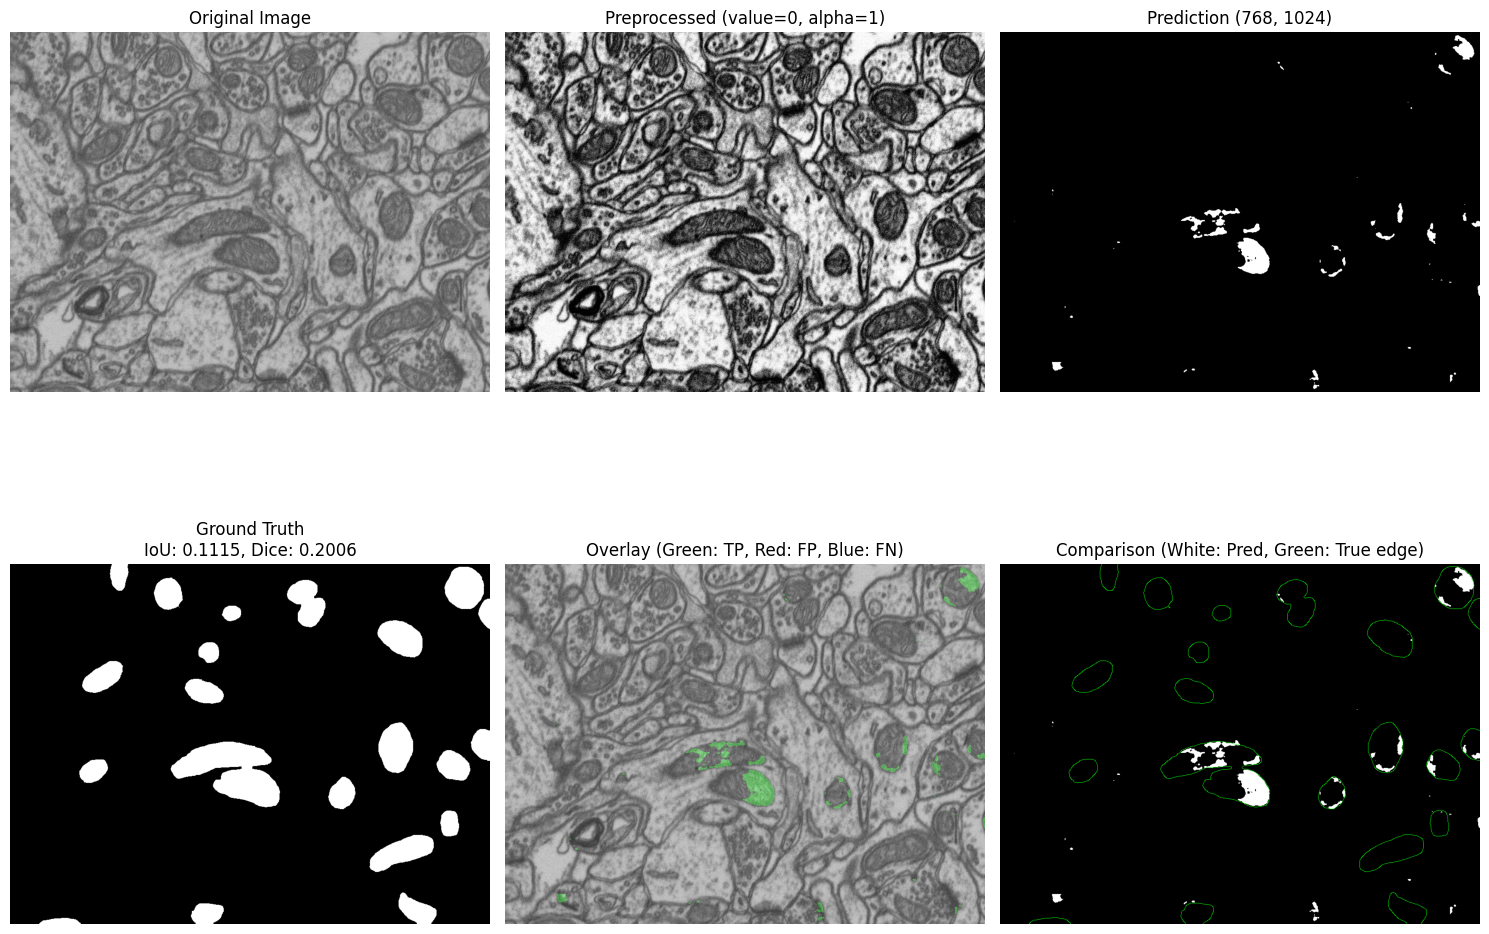

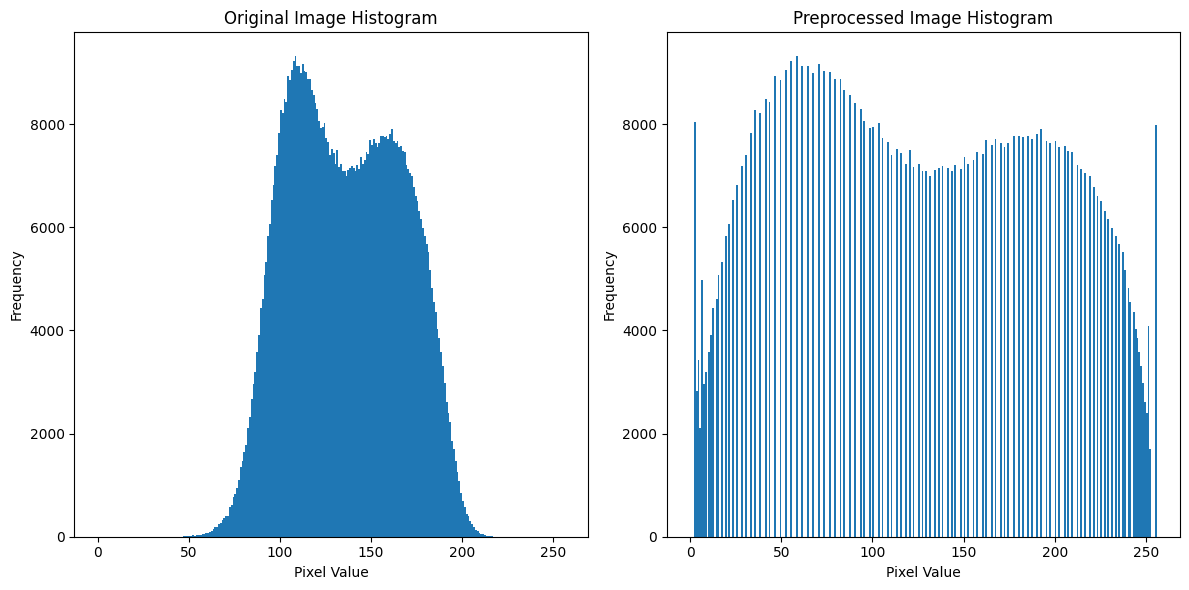

所有结果已保存至 test/predictData 目录
预测完成！
最终指标: IoU=0.1115, Dice=0.2006


In [44]:
def save_prediction_results(model_path, image_path, mask_path=None, save_dir="test/predictData", patch_size=256, 
                            stride=128, value=-30, alpha=1.3, device=None):
    """
    加载模型、执行预测并保存结果
    
    参数:
        model_path: 模型文件路径
        image_path: 图像路径
        mask_path: 掩码路径，可选
        save_dir: 保存结果的目录
        patch_size: 处理的patch大小
        stride: patch滑动的步长
        value: 亮度调整值
        alpha: 对比度调整系数
        device: 使用的设备，None则自动选择
    """
    # 设置设备
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 确保保存目录存在
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"使用设备: {device}")
    print(f"模型路径: {model_path}")
    print(f"图像路径: {image_path}")
    print(f"掩码路径: {mask_path}")
    print(f"保存目录: {save_dir}")
    print(f"Patch大小: {patch_size}")
    print(f"Stride: {stride}")
    print(f"亮度调整值: {value}")
    print(f"对比度系数: {alpha}")
    
    # 读取原始图像
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 获取文件名（不含扩展名）
    file_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # 使用您的preprocess方法预处理图像
    # 创建一个空白mask作为placeholder，如果没有提供真实mask
    dummy_mask = np.zeros_like(original_img[:,:,0]) if mask_path is None else cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # 初始化预处理器
    preprocessor = ImagePreprocessor()  # 假设您的类名是ImagePreprocessor
    
    # 应用预处理
    preprocessed_img, preprocessed_mask = preprocessor.preprocess(
        original_img, 
        dummy_mask, 
        patch_size=patch_size,
        value=value, 
        alpha=alpha
    )
    
    # 保存预处理后的图像
    if len(preprocessed_img.shape) == 3:
        preprocessed_img_display = preprocessed_img.copy()
    else:
        preprocessed_img_display = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2BGR)
    
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_preprocessed.png"), preprocessed_img_display)
    
    # 加载模型
    model = load_model(model_path, device)
    
    # 执行预测，显式指定stride参数
    pred_mask = predict(
        model=model,
        image_path=image_path,  # 原始图像路径，predict内部会调用相同的预处理
        mask_path=mask_path,
        device=device,
        save_dir=save_dir,
        patch_size=patch_size,
        stride=stride,  # 确保与训练时一致
        value=value,
        alpha=alpha
    )
    
    # 计算评估指标（如果提供了真实掩码）
    metrics_result = {}
    
    # 真实掩码（如果提供）
    if mask_path and os.path.exists(mask_path):
        # 读取真实掩码
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # 保存二值化的真实掩码
        _, true_mask_bin = cv2.threshold(true_mask, 127, 255, cv2.THRESH_BINARY)
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_true_mask_binary.png"), true_mask_bin)
        
        # 计算IoU和Dice系数
        # 首先将掩码转换为torch tensor
        pred_tensor = torch.from_numpy(pred_mask.astype(np.float32))
        true_tensor = torch.from_numpy((true_mask_bin > 0).astype(np.float32))
        
        # 确保尺寸一致
        if pred_tensor.shape != true_tensor.shape:
            print(f"警告: 预测掩码 ({pred_tensor.shape}) 和真实掩码 ({true_tensor.shape}) 尺寸不一致")
            # 调整预测掩码大小以匹配真实掩码
            pred_tensor = torch.nn.functional.interpolate(
                pred_tensor.unsqueeze(0).unsqueeze(0), 
                size=true_tensor.shape, 
                mode='nearest'
            ).squeeze(0).squeeze(0)
        
        # 计算评估指标
        iou, dice = calculate_metrics(pred_tensor, true_tensor)
        metrics_result = {"IoU": iou, "Dice": dice}
        
        print(f"IoU: {iou:.4f}")
        print(f"Dice: {dice:.4f}")
        
        # 将指标写入文件
        with open(os.path.join(save_dir, f"{file_name}_metrics.txt"), 'w') as f:
            f.write(f"IoU: {iou:.4f}\n")
            f.write(f"Dice: {dice:.4f}\n")
        
        # 生成对比图
        comparison = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
        
        # 预测掩码为白色
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255
        comparison[pred_mask_bin > 0] = [255, 255, 255]  # 白色
        
        # 添加真实掩码的轮廓 (绿色)
        true_mask_edges = cv2.Canny(true_mask_bin, 100, 200)
        comparison[true_mask_edges > 0] = [0, 255, 0]  # 绿色
        
        # 保存对比图
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_comparison.png"), comparison)
        
        # 创建彩色掩码图 (正确:绿色, 错误:红色, 漏检:蓝色)
        color_mask = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
        
        true_mask_bin = true_mask_bin > 0
        pred_mask_bin = pred_mask_bin > 0
        
        # 正确检测 (绿色) - 真实掩码和预测掩码都为1
        color_mask[np.logical_and(true_mask_bin, pred_mask_bin)] = [0, 255, 0]
        
        # 错误检测 (红色) - 真实掩码为0但预测掩码为1
        color_mask[np.logical_and(np.logical_not(true_mask_bin), pred_mask_bin)] = [0, 0, 255]
        
        # 漏检 (蓝色) - 真实掩码为1但预测掩码为0
        color_mask[np.logical_and(true_mask_bin, np.logical_not(pred_mask_bin))] = [255, 0, 0]
        
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_color_mask.png"), color_mask)
        
        # 将彩色掩码叠加到原始图像上
        alpha_overlay = 0.5
        overlay = cv2.addWeighted(original_img, 1, color_mask, alpha_overlay, 0)
        cv2.imwrite(os.path.join(save_dir, f"{file_name}_overlay.png"), overlay)
    
    # 保存预测掩码（不同格式）
    # 二值化掩码
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8) * 255
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_binary.png"), pred_mask_bin)
    
    # 轮廓标记
    orig_with_contours = original_img.copy()
    contours, _ = cv2.findContours(pred_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(orig_with_contours, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_with_contours.png"), orig_with_contours)
    
    # 半透明叠加
    pred_mask_color = cv2.cvtColor(pred_mask_bin, cv2.COLOR_GRAY2BGR)
    pred_mask_color[pred_mask_bin > 0] = [0, 255, 0]  # 将预测区域标记为绿色
    alpha_overlay = 0.3
    overlay = cv2.addWeighted(original_img, 1, pred_mask_color, alpha_overlay, 0)
    cv2.imwrite(os.path.join(save_dir, f"{file_name}_prediction_overlay.png"), overlay)
    
    # 可视化结果（使用matplotlib）- 添加预处理图像
    plt.figure(figsize=(15, 12))  # 增加画布大小以适应更多的子图
    
    # 原始图像
    plt.subplot(231)
    plt.imshow(original_img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    # 预处理后的图像
    plt.subplot(232)
    if len(preprocessed_img.shape) == 3:
        plt.imshow(cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(preprocessed_img, cmap='gray')
    plt.title(f'Preprocessed (value={value}, alpha={alpha})')
    plt.axis('off')
    
    # 预测掩码
    plt.subplot(233)
    plt.imshow(pred_mask, cmap='gray')
    plt.title(f'Prediction {pred_mask.shape}')
    plt.axis('off')
    
    # 真实掩码（如果提供）和指标信息
    if mask_path and os.path.exists(mask_path):
        plt.subplot(234)
        plt.imshow(true_mask, cmap='gray')
        plt.title(f'Ground Truth\nIoU: {metrics_result["IoU"]:.4f}, Dice: {metrics_result["Dice"]:.4f}')
        plt.axis('off')
        
        # 叠加显示（预测掩码轮廓叠加在真实掩码上）
        plt.subplot(235)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title('Overlay (Green: TP, Red: FP, Blue: FN)')
        plt.axis('off')
        
        # 对比图
        plt.subplot(236)
        plt.imshow(cv2.cvtColor(comparison, cv2.COLOR_BGR2RGB))
        plt.title('Comparison (White: Pred, Green: True edge)')
        plt.axis('off')
    else:
        # 如果没有真实掩码，则调整布局
        plt.subplot(234)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title('Prediction Overlay')
        plt.axis('off')
        
        # 预测掩码（二值化）
        plt.subplot(235)
        plt.imshow(pred_mask_bin, cmap='gray')
        plt.title('Binary Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    
    # 保存可视化结果
    plt.savefig(os.path.join(save_dir, f"{file_name}_visualization.png"), dpi=300, bbox_inches='tight')
    
    # 显示可视化结果
    plt.show()
    
    # 创建直方图比较
    plt.figure(figsize=(12, 6))
    
    # 原始图像直方图
    if len(original_img.shape) == 3:
        orig_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    else:
        orig_gray = original_img
    
    plt.subplot(121)
    plt.hist(orig_gray.ravel(), 256, [0, 256])
    plt.title('Original Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # 预处理后图像直方图
    preproc_gray = preprocessed_img
    if len(preprocessed_img.shape) == 3:
        preproc_gray = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2GRAY)
    
    plt.subplot(122)
    plt.hist(preproc_gray.ravel(), 256, [0, 256])
    plt.title('Preprocessed Image Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{file_name}_histograms.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"所有结果已保存至 {save_dir} 目录")
    print("预测完成！")
    
    return pred_mask, metrics_result if mask_path and os.path.exists(mask_path) else None

# 设置参数
model_path = "models/UnetTrain/overlaping_unet_segmentation_try3.3K.pth"  # 模型路径
image_path = "dataset/Lucchi++/Train_In/mask0000.png"  # 测试图片路径
mask_path = "dataset/Lucchi++/Train_Out/0.png"  # 真实掩码路径（如果有）
save_dir = "test/predictData"  # 结果保存目录
patch_size = 256  # patch大小，建议与训练时一致
stride = 64  # 步长，建议与训练时一致

# 执行预测并保存结果
pred_mask, metrics = save_prediction_results(
    model_path=model_path,
    image_path=image_path,
    mask_path=mask_path,
    save_dir=save_dir,
    patch_size=patch_size,
    stride=stride,  # 明确指定步长
    value=-30,
    alpha=1.3
)

if metrics:
    print(f"最终指标: IoU={metrics['IoU']:.4f}, Dice={metrics['Dice']:.4f}")